In [1]:
# Path to google drive folder
# %cd /content/drive/MyDrive/Colab Notebooks/Disertasi-Ahmad-Rofiqul/002. Laporan-eksperimen
# %cd /content/drive/MyDrive/Colab Notebooks/Disertasi-Ahmad-Rofiqul/002.Experiment_SWI_16052024/

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor, DMatrix, cv
import matplotlib.pyplot as plt

# from sklearn.ensemble import IsolationForest, VotingClassifier
# from sklearn.neighbors import LocalOutlierFactor
# from sklearn.svm import OneClassSVM
# from sklearn.covariance import EllipticEnvelope
# from pyod.models.hbos import HBOS
# from sklearn.cluster import DBSCAN
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, roc_auc_score, roc_curve, auc
# from sklearn.model_selection import train_test_split
# from sklearn.base import BaseEstimator, OutlierMixin
# from scipy.spatial.distance import mahalanobis

In [3]:

# Load the dataset
# df = pd.read_csv('/mnt/data/09_06_0_N2O_Agriculture_TestTraining_IDO_CV.ipynb')
file_path = 'dataset/09_05_4_1_AgricultureOutliers_HardVotingBased_IDO.csv'
df= pd.read_csv(file_path)

# Ensure all columns are of the appropriate type
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category').cat.codes
    elif not pd.api.types.is_numeric_dtype(df[col]):
        df[col] = df[col].astype('float')

X = df.drop('N2O', axis=1)
y = df['N2O']

test_sizes = [0.2, 0.25, 0.3, 0.35]
results = []


In [4]:

# Define evaluation function
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# Function to perform no cross-validation
def no_cross_validation(X_train, y_train, X_test, y_test, params):
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return evaluate_model(y_test, y_pred)

# # Function to perform sklearn cross_val_score
# def sklearn_cross_val_score_eval(X, y, params):
#     model = XGBRegressor(**params)
#     mae_scores = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
#     mse_scores = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
#     rmse_scores = np.sqrt(mse_scores)
#     r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
#     return mae_scores.mean(), mse_scores.mean(), rmse_scores.mean(), r2_scores.mean()

# Function to perform xgb.cv
def xgb_cv_eval(X, y, params):
    dtrain = DMatrix(X, label=y)
    cv_results = cv(params, dtrain, num_boost_round=100, nfold=5, metrics=['mae', 'rmse'], early_stopping_rounds=10, seed=42)
    mae = cv_results['test-mae-mean'].iloc[-1]
    rmse = cv_results['test-rmse-mean'].iloc[-1]
    mse = rmse ** 2
    r2 = 1 - (mse / np.var(y))
    return mae, mse, rmse, r2


In [5]:
import time

## Perform Grid Search

In [6]:
# Function to perform hyperparameter tuning and evaluation
def perform_gridsearch(X, y, test_size):
    results = {'Test Size': [], 'Method': [], 'Best Params': [], 'Start Time': [], 'End Time': [], 'Duration (s)': [], 'MAE': [], 'MSE': [], 'RMSE': [], 'R2': []}
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Grid Search
    param_grid = {
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9]
    }
    grid_search = GridSearchCV(
        estimator=XGBRegressor(n_estimators=100, random_state=42),
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=3,
        n_jobs=-1,
        verbose=0,
        return_train_score=True
    )
    
    start_time = time.time()
    start_time_str = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start_time))
    print(f"Starting Grid Search for test size {test_size}...")
    grid_search.fit(X_train, y_train)
    end_time = time.time()
    end_time_str = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end_time))
    duration = end_time - start_time
    print(f"Grid Search completed in {duration:.2f} seconds.")
    best_params = grid_search.best_params_
    print(f"Best parameters from Grid Search: {best_params}")

    # Plot Grid Search process
    plt.figure(figsize=(12, 6))
    plt.plot(-grid_search.cv_results_['mean_test_score'], marker='o', label='Mean Test Score (MSE)')
    plt.plot(-grid_search.cv_results_['mean_train_score'], marker='o', label='Mean Train Score (MSE)')
    plt.xlabel('Parameter Combination Index')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title(f'Grid Search Evaluation - Test Size: {test_size}')
    plt.legend()
    plt.show()

    # No Cross Validation
    mae, mse, rmse, r2 = no_cross_validation(X_train, y_train, X_test, y_test, best_params)
    results['Test Size'].append(test_size)
    results['Method'].append('No Cross Validation (Grid Search)')
    results['Best Params'].append(best_params)
    results['Start Time'].append(start_time_str)
    results['End Time'].append(end_time_str)
    results['Duration (s)'].append(duration)
    results['MAE'].append(mae)
    results['MSE'].append(mse)
    results['RMSE'].append(rmse)
    results['R2'].append(r2)

    # # Sklearn cross_val_score
    # mae, mse, rmse, r2 = sklearn_cross_val_score_eval(X, y, best_params)
    # results['Test Size'].append(test_size)
    # results['Method'].append('Sklearn cross_val_score (Grid Search)')
    # results['Best Params'].append(best_params)
    # results['Start Time'].append(start_time_str)
    # results['End Time'].append(end_time_str)
    # results['Duration (s)'].append(duration)
    # results['MAE'].append(mae)
    # results['MSE'].append(mse)
    # results['RMSE'].append(rmse)
    # results['R2'].append(r2)
    
    # xgb.cv
    xgb_params = best_params.copy()
    xgb_params['objective'] = 'reg:squarederror'
    mae, mse, rmse, r2 = xgb_cv_eval(X, y, xgb_params)
    results['Test Size'].append(test_size)
    results['Method'].append('xgb.cv (Grid Search)')
    results['Best Params'].append(best_params)
    results['Start Time'].append(start_time_str)
    results['End Time'].append(end_time_str)
    results['Duration (s)'].append(duration)
    results['MAE'].append(mae)
    results['MSE'].append(mse)
    results['RMSE'].append(rmse)
    results['R2'].append(r2)

    return results

## Perform Random Search

In [7]:
# Function to perform hyperparameter tuning and evaluation
def perform_randomsearch(X, y, test_size):
    results = {'Test Size': [], 'Method': [], 'Best Params': [], 'Start Time': [], 'End Time': [], 'Duration (s)': [], 'MAE': [], 'MSE': [], 'RMSE': [], 'R2': []}
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    param_distributions = {
        'learning_rate': [0.01, 0.1, 0.3, 0.5, 0.7, 1.0],
        'max_depth': [3, 5, 7, 9, 11],
        'min_child_weight': [1, 2, 3, 4, 5],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    }
    random_search = RandomizedSearchCV(
        estimator=XGBRegressor(n_estimators=100, random_state=42),
        param_distributions=param_distributions,
        n_iter=50,
        scoring='neg_mean_squared_error',
        cv=3,
        n_jobs=-1,
        verbose=0,
        random_state=42,
        return_train_score=True
    )
    
    start_time = time.time()
    start_time_str = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start_time))
    print(f"Starting Random Search for test size {test_size}...")
    random_search.fit(X_train, y_train)
    end_time = time.time()
    end_time_str = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end_time))
    duration = end_time - start_time
    print(f"Random Search completed in {duration:.2f} seconds.")
    best_params = random_search.best_params_
    print(f"Best parameters from Random Search: {best_params}")

    # Plot Random Search process
    plt.figure(figsize=(12, 6))
    plt.plot(-random_search.cv_results_['mean_test_score'], marker='o', label='Mean Test Score (MSE)')
    plt.plot(-random_search.cv_results_['mean_train_score'], marker='o', label='Mean Train Score (MSE)')
    plt.xlabel('Parameter Combination Index')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title(f'Random Search Evaluation - Test Size: {test_size}')
    plt.legend()
    plt.show()
    
    # No Cross Validation
    mae, mse, rmse, r2 = no_cross_validation(X_train, y_train, X_test, y_test, best_params)
    results['Test Size'].append(test_size)
    results['Method'].append('No Cross Validation (Random Search)')
    results['Best Params'].append(best_params)
    results['Start Time'].append(start_time_str)
    results['End Time'].append(end_time_str)
    results['Duration (s)'].append(duration)
    results['MAE'].append(mae)
    results['MSE'].append(mse)
    results['RMSE'].append(rmse)
    results['R2'].append(r2)

    # # Sklearn cross_val_score
    # mae, mse, rmse, r2 = sklearn_cross_val_score_eval(X, y, best_params)
    # results['Test Size'].append(test_size)
    # results['Method'].append('Sklearn cross_val_score (Random Search)')
    # results['Best Params'].append(best_params)
    # results['Start Time'].append(start_time_str)
    # results['End Time'].append(end_time_str)
    # results['Duration (s)'].append(duration)
    # results['MAE'].append(mae)
    # results['MSE'].append(mse)
    # results['RMSE'].append(rmse)
    # results['R2'].append(r2)
    
    # xgb.cv
    xgb_params = best_params.copy()
    xgb_params['objective'] = 'reg:squarederror'
    mae, mse, rmse, r2 = xgb_cv_eval(X, y, xgb_params)
    results['Test Size'].append(test_size)
    results['Method'].append('xgb.cv (Random Search)')
    results['Best Params'].append(best_params)
    results['Start Time'].append(start_time_str)
    results['End Time'].append(end_time_str)
    results['Duration (s)'].append(duration)
    results['MAE'].append(mae)
    results['MSE'].append(mse)
    results['RMSE'].append(rmse)
    results['R2'].append(r2)
    
    return results

Starting Grid Search for test size 0.2...
Grid Search completed in 40.92 seconds.
Best parameters from Grid Search: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.9}


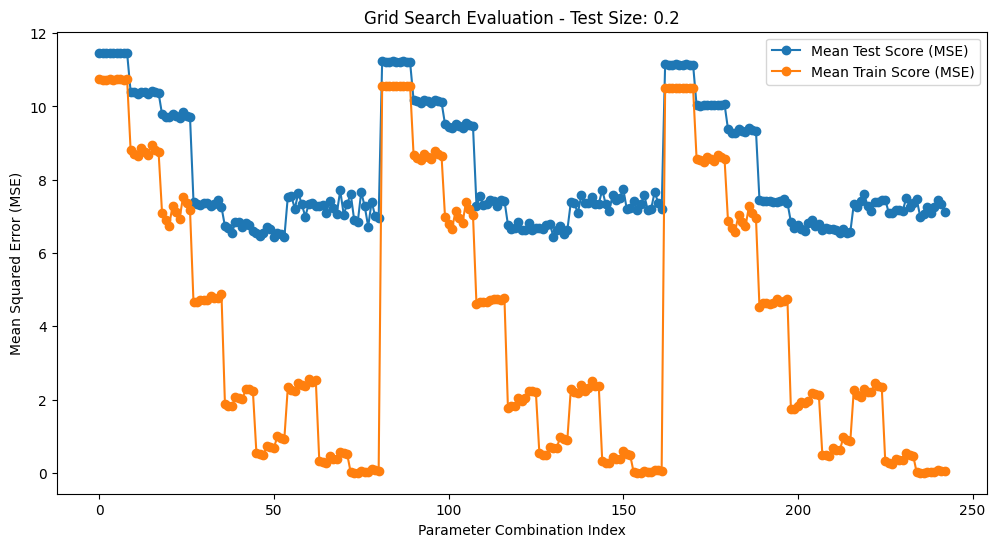

Starting Grid Search for test size 0.25...
Grid Search completed in 38.41 seconds.
Best parameters from Grid Search: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.9}


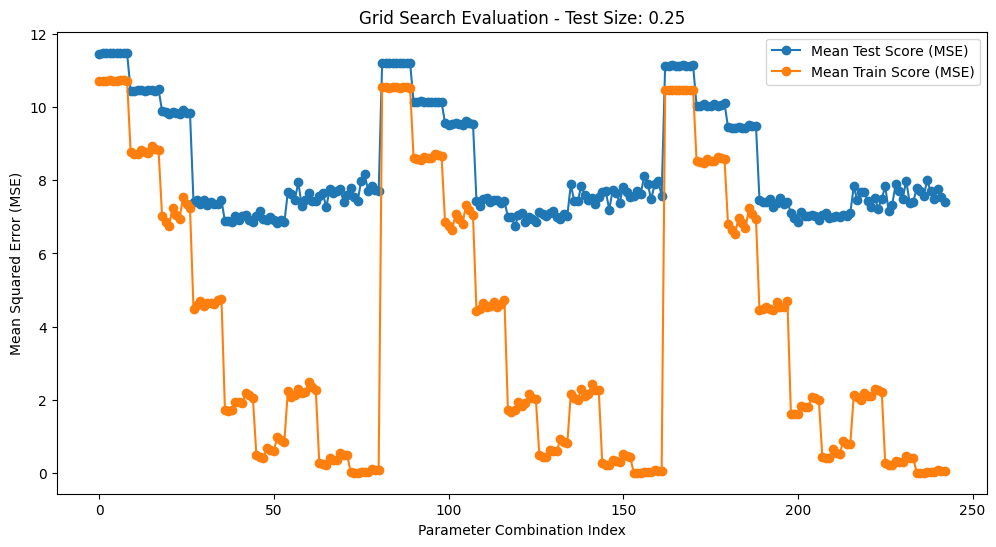

Starting Grid Search for test size 0.3...
Grid Search completed in 40.43 seconds.
Best parameters from Grid Search: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.8}


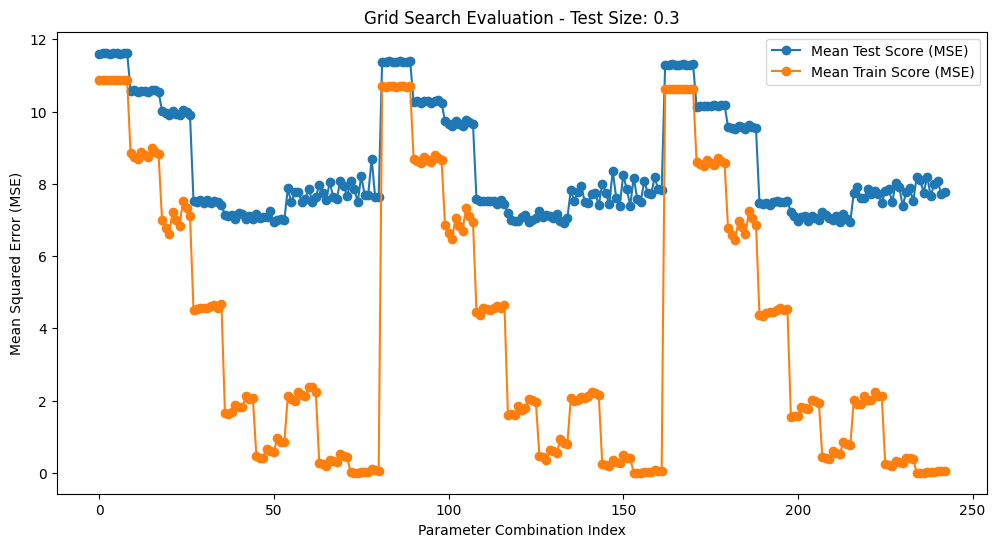

Starting Grid Search for test size 0.35...
Grid Search completed in 40.96 seconds.
Best parameters from Grid Search: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.8}


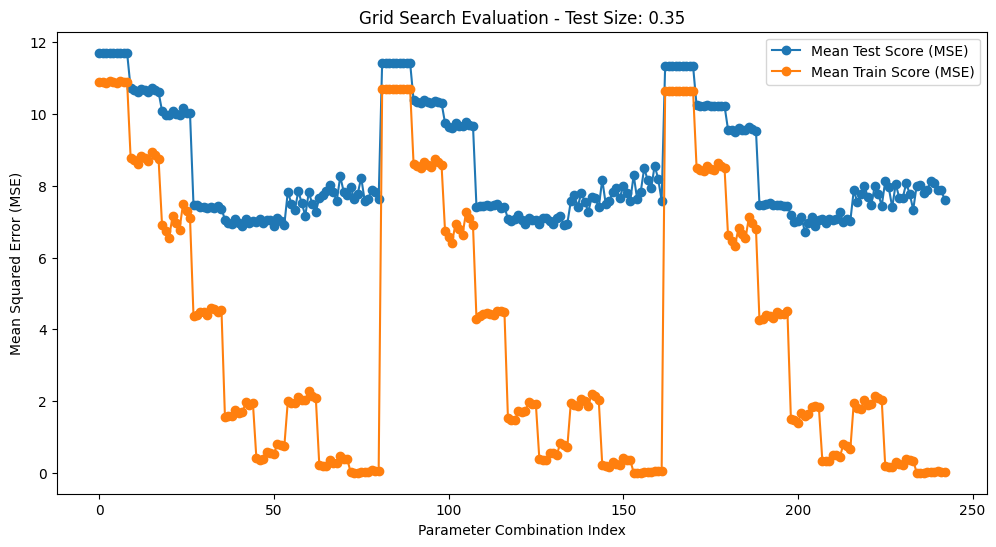

[   Test Size                             Method  \
 0        0.2  No Cross Validation (Grid Search)   
 1        0.2               xgb.cv (Grid Search)   
 
                                          Best Params           Start Time  \
 0  {'colsample_bytree': 0.7, 'learning_rate': 0.1...  2024-06-04 19:22:49   
 1  {'colsample_bytree': 0.7, 'learning_rate': 0.1...  2024-06-04 19:22:49   
 
               End Time  Duration (s)       MAE       MSE      RMSE        R2  
 0  2024-06-04 19:23:30     40.920203  1.729272  6.241339  2.498267  0.654950  
 1  2024-06-04 19:23:30     40.920203  1.711477  6.024727  2.454532  0.655214  ,
    Test Size                             Method  \
 0       0.25  No Cross Validation (Grid Search)   
 1       0.25               xgb.cv (Grid Search)   
 
                                          Best Params           Start Time  \
 0  {'colsample_bytree': 0.8, 'learning_rate': 0.1...  2024-06-04 19:23:32   
 1  {'colsample_bytree': 0.8, 'learning_rate': 0.1.

In [8]:
# Perform testing for each test size and optimization method
gridsearch = []

for test_size in test_sizes:
    results = perform_gridsearch(X, y, test_size)
    # results = perform_randomsearch(X, y, test_size)
    gridsearch.append(pd.DataFrame(results))

gridsearch

In [9]:
final_results_df = pd.concat(gridsearch, ignore_index=True)
# gridsearchdf=pd.DataFrame(gridsearch)
final_results_df.to_csv('dataset/0908_0_1_00_xgboost_evaluation_CV_GridSearch_IDO_XGBCV.csv', index=False)


In [10]:
# final_results_df

In [11]:
# final_results_df.to_csv('dataset/0908_0_1_xgboost_evaluation_CV_GridSearch_IDO.csv', index=False)


Starting Random Search for test size 0.2...
Random Search completed in 14.33 seconds.
Best parameters from Random Search: {'subsample': 0.8, 'min_child_weight': 4, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.7}


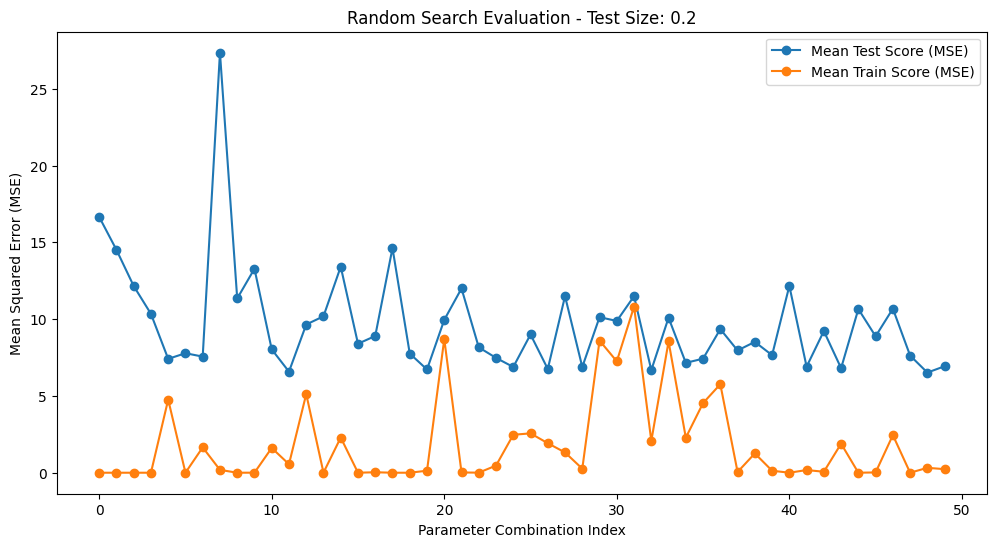

Starting Random Search for test size 0.25...
Random Search completed in 14.43 seconds.
Best parameters from Random Search: {'subsample': 0.6, 'min_child_weight': 2, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.7}


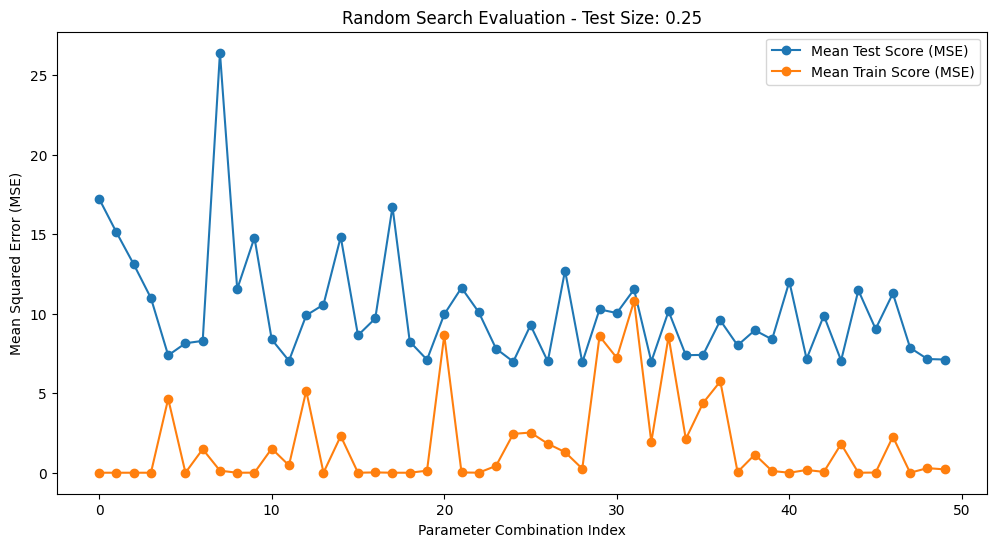

Starting Random Search for test size 0.3...
Random Search completed in 12.83 seconds.
Best parameters from Random Search: {'subsample': 0.8, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


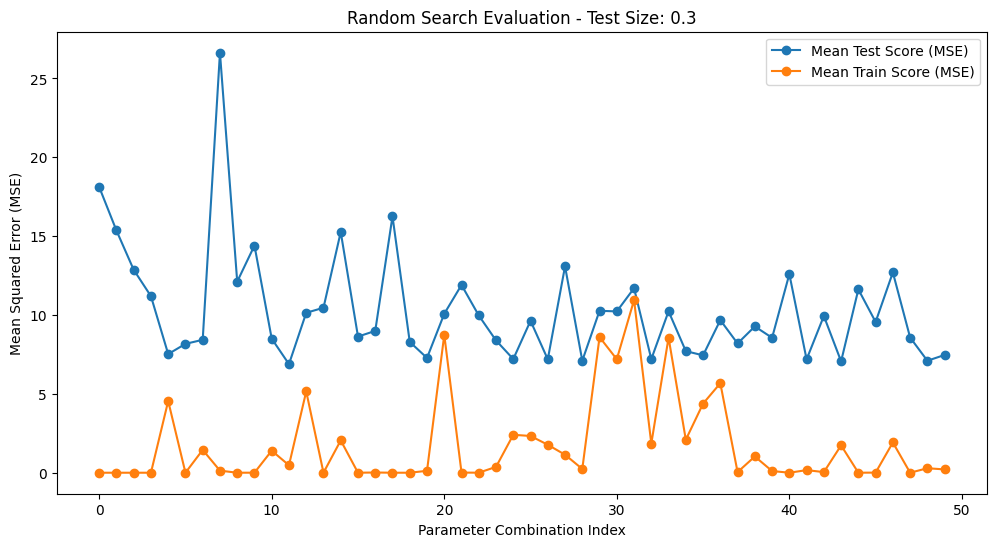

Starting Random Search for test size 0.35...
Random Search completed in 12.61 seconds.
Best parameters from Random Search: {'subsample': 0.8, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


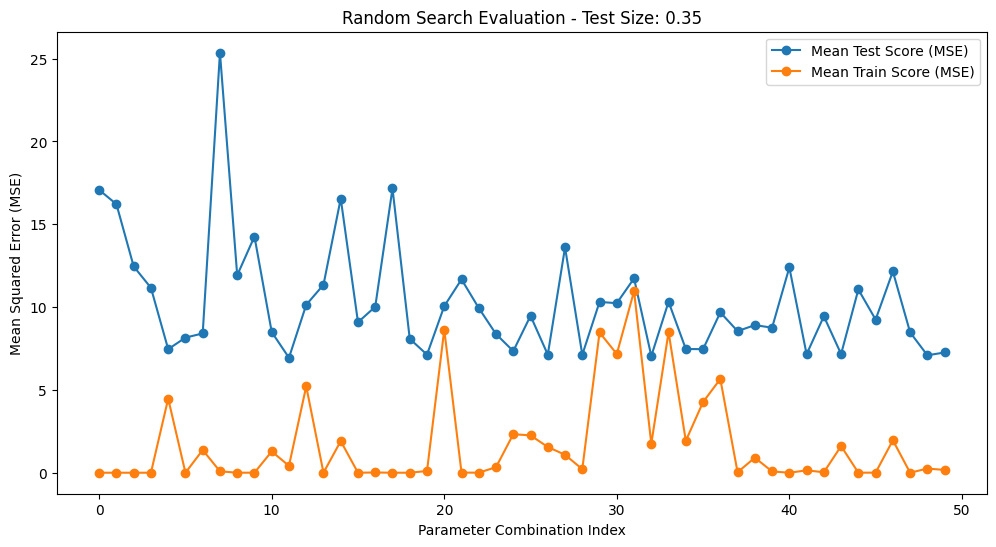

,Test Size,Method,Best Params,Start Time,End Time,Duration (s),MAE,MSE,RMSE,R2
0,0.20,No Cross Validation (Random Search),"{'subsample': 0.8, 'min_child_weight': 4, 'max...",2024-06-04 19:25:36,2024-06-04 19:25:51,14.333387,1.650670,6.091417,2.468080,0.663238
1,0.20,xgb.cv (Random Search),"{'subsample': 0.8, 'min_child_weight': 4, 'max...",2024-06-04 19:25:36,2024-06-04 19:25:51,14.333387,1.675666,5.880531,2.424981,0.663466
2,0.25,No Cross Validation (Random Search),"{'subsample': 0.6, 'min_child_weight': 2, 'max...",2024-06-04 19:25:53,2024-06-04 19:26:08,14.430002,1.742158,6.159491,2.481832,0.648081
3,0.25,xgb.cv (Random Search),"{'subsample': 0.6, 'min_child_weight': 2, 'max...",2024-06-04 19:25:53,2024-06-04 19:26:08,14.430002,1.732441,6.160994,2.482135,0.647415
4,0.30,No Cross Validation (Random Search),"{'subsample': 0.8, 'min_child_weight': 2, 'max...",2024-06-04 19:26:10,2024-06-04 19:26:23,12.834438,1.699448,6.260887,2.502176,0.625598
5,0.30,xgb.cv (Random Search),"{'subsample': 0.8, 'min_child_weight': 2, 'max...",2024-06-04 19:26:10,2024-06-04 19:26:23,12.834438,1.697374,6.004954,2.450501,0.656345
6,0.35,No Cross Validation (Random Search),"{'subsample': 0.8, 'min_child_weight': 2, 'max...",2024-06-04 19:26:25,2024-06-04 19:26:37,12.611943,1.727328,6.511511,2.551766,0.597811
7,0.35,xgb.cv (Random Search),"{'subsample': 0.8, 'min_child_weight': 2, 'max...",2024-06-04 19:26:25,2024-06-04 19:26:37,12.611943,1.697374,6.004954,2.450501,0.656345


In [12]:
# Perform testing for each test size and optimization method
random_results = []

for test_size in test_sizes:
    # results = perform_gridsearch(X, y, test_size)
    results = perform_randomsearch(X, y, test_size)
    random_results.append(pd.DataFrame(results))

# Combine all results into a single DataFrame
random_results_df = pd.concat(random_results, ignore_index=True)
random_results_df

In [13]:
random_results_df.to_csv('dataset/0908_0_2_00_xgboost_evaluation_CV_RandomSearch_IDO_XGBCV.csv', index=False)


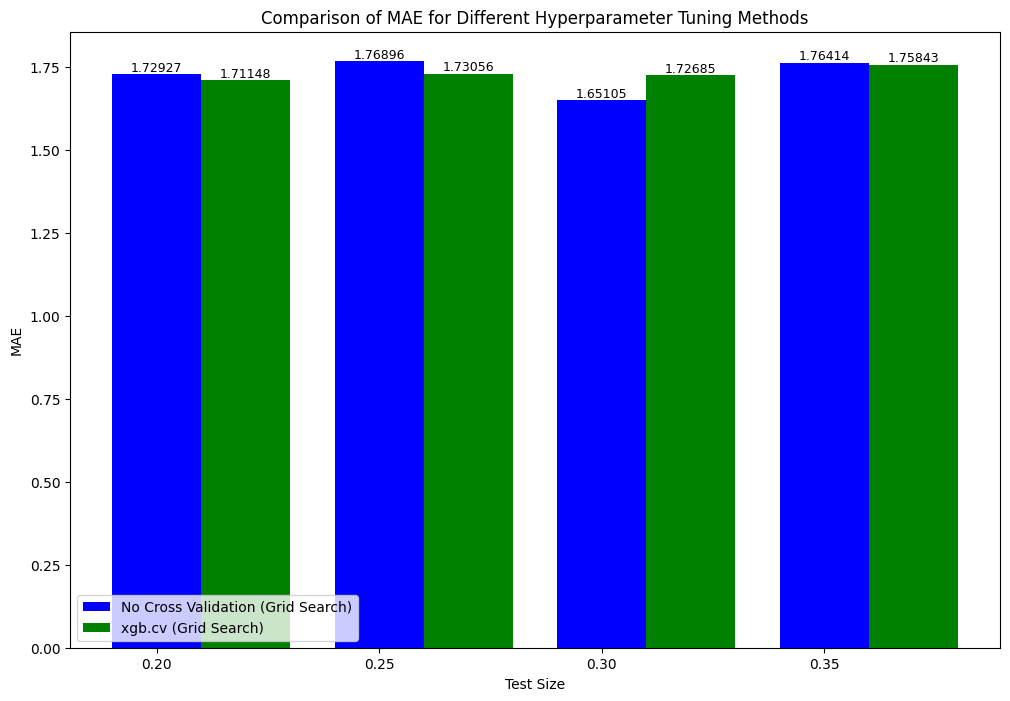

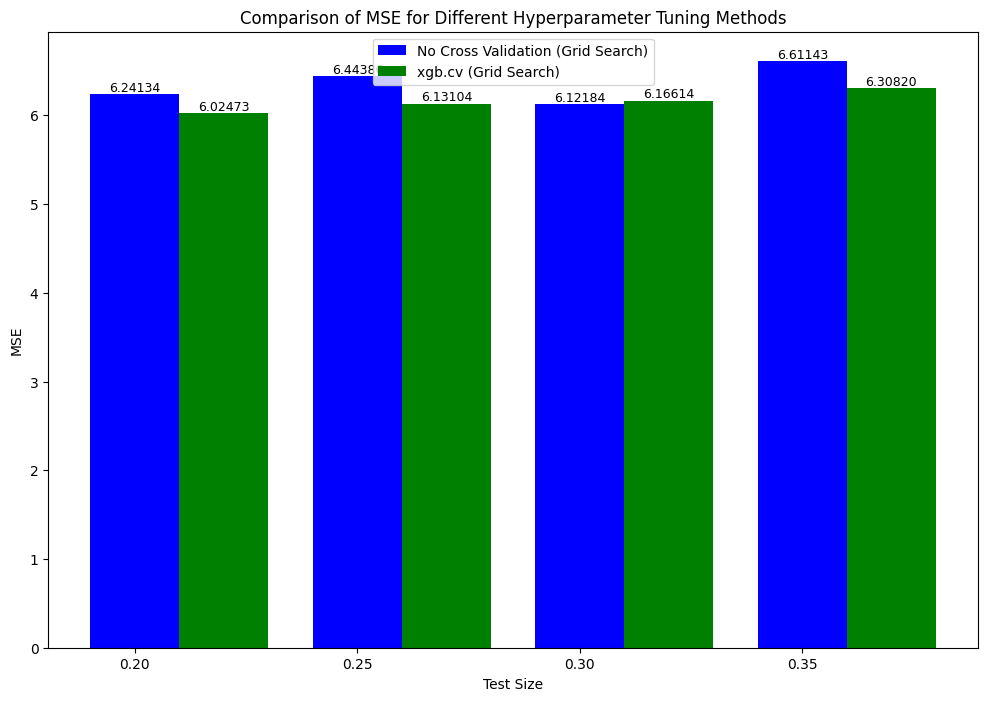

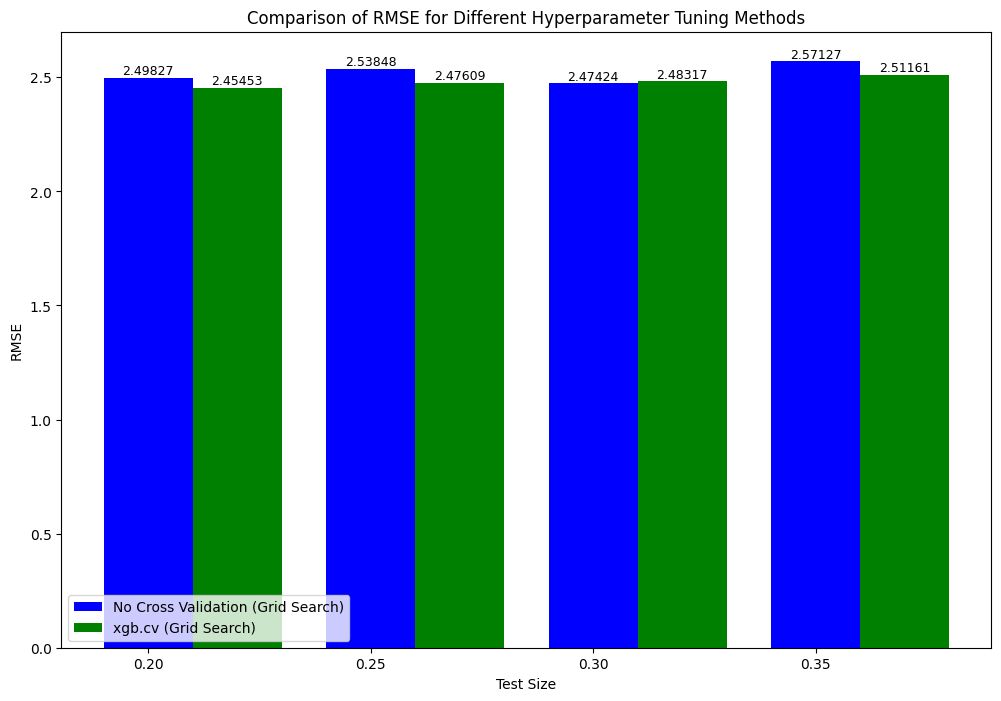

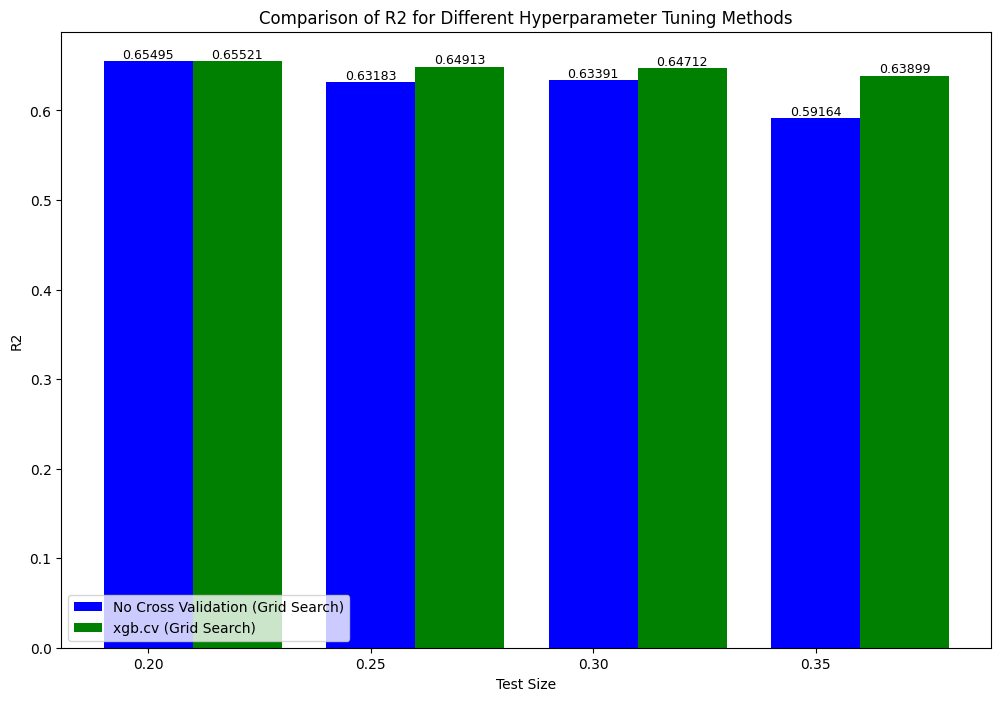

In [14]:

# Display the DataFrame
# import ace_tools as tools; tools.display_dataframe_to_user(name="Hyperparameter Tuning Results", dataframe=final_results_df)

# Visualization of performance metrics
metrics = ['MAE', 'MSE', 'RMSE', 'R2']
methods = final_results_df['Method'].unique()
colors = ['b', 'g', 'r', 'c', 'm']  # Adjust or expand this list as needed

for metric in metrics:
    plt.figure(figsize=(12, 8))
    for i, method in enumerate(methods):
        subset = final_results_df[final_results_df['Method'] == method]
        plt.bar(subset['Test Size'] + i * 0.02, subset[metric], width=0.02, label=method, color=colors[i % len(colors)])
        
        for x, y in zip(subset['Test Size'], subset[metric]):
            plt.text(x + i * 0.02, y, f'{y:.5f}', ha='center', va='bottom', fontsize=9)

    plt.xlabel('Test Size')
    plt.ylabel(metric)
    plt.title(f'Comparison of {metric} for Different Hyperparameter Tuning Methods')
    plt.xticks(test_sizes)
    plt.legend()
    plt.show()
